In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,INTC,26.78,26.88,26.45,26.87,32165978.0,122840.0,26.70
2016-01-05 05:00:00+00:00,INTC,26.84,26.88,26.50,26.74,17905707.0,87505.0,26.67
2016-01-06 05:00:00+00:00,INTC,26.28,26.50,25.93,26.15,26939523.0,121984.0,26.22
2016-01-07 05:00:00+00:00,INTC,25.52,26.09,25.17,25.17,41368839.0,163862.0,25.48
2016-01-08 05:00:00+00:00,INTC,25.37,25.47,24.84,24.91,32404640.0,142641.0,25.15


<Axes: xlabel='timestamp'>

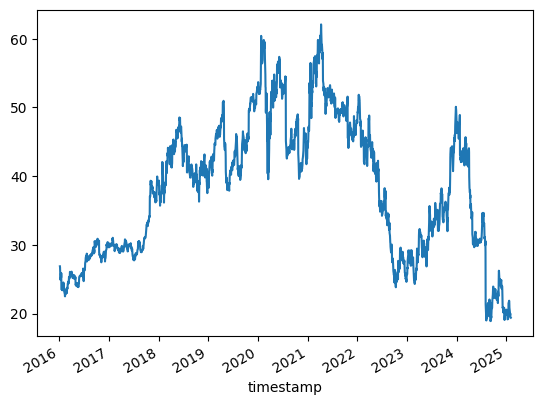

In [2]:
data['close'].plot()

In [3]:
data.drop(columns=["symbol"], inplace=True)

In [4]:
import numpy as np
import pandas as pd

data["price"] = data["close"]
data["volatility"] = data["close"].shift(-1).dropna().pct_change().rolling(window=10).std()
data["mva_10"] = data["close"].rolling(window=10).mean()
data["mva_30"] = data["close"].rolling(window=30).mean()
data["yesterday_close"] = data["close"].shift(-1)
data.dropna(inplace=True)

features = ["yesterday_close","volatility", "mva_10", "mva_30", "price"]

def create_labels(price, window=10, threshold=0.005):
    delta = price.shift(-window) - price
    delta_pct = delta / price
    return np.where(delta_pct > threshold, "buy", np.where(delta_pct < -threshold, "sell", "hold"))
 

data["rebalance_action"] = create_labels(data["close"], window=15, threshold=0.025)


In [5]:
data["rebalance_action"].value_counts()

rebalance_action
buy     852
sell    711
hold    692
Name: count, dtype: int64

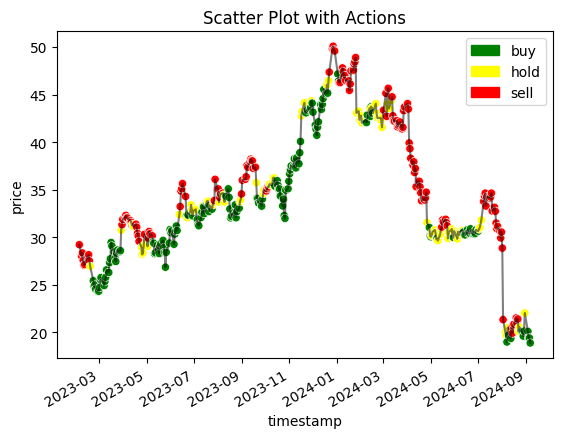

In [6]:
import matplotlib.patches as mpatches

data_reset = data.copy()
data_reset = data[-500:-100].copy()
data_reset["timestamp"] = data_reset.index
data_reset["action_enum"] = data_reset["rebalance_action"].apply(lambda x: 1 if x == "buy" else -1 if x == "sell" else 0)
sns.scatterplot(data=data_reset, x=data_reset["timestamp"], y=data_reset["close"], hue='action_enum', palette={-1: 'red', 0: 'yellow', 1: 'green'})
data_reset["close"].plot(color='black', alpha=0.5)
plt.title('Scatter Plot with Actions')
plt.xlabel('timestamp')
plt.ylabel('price')
legend_handles = [
    mpatches.Patch(color='green', label='buy'),
    mpatches.Patch(color='yellow', label='hold'),
    mpatches.Patch(color='red', label='sell'),
]
plt.legend(handles=legend_handles)
plt.show()


<Axes: xlabel='timestamp'>

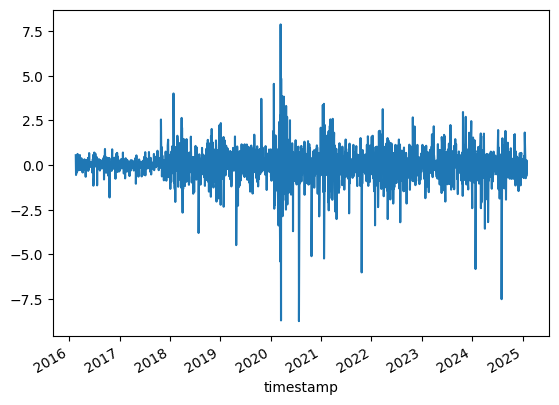

In [7]:
data["allocation_pct"] = data["close"].diff()
data.dropna(inplace=True)
data["allocation_pct"].plot()

In [8]:
from sklearn.model_selection import train_test_split

X = data[features]
y_classification = data["rebalance_action"]
y_regression = data["allocation_pct"]

X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, shuffle=False)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, shuffle=False)


X_train.drop("price", axis=1, inplace=True)
X_test_price = X_test["price"]
X_test.drop("price", axis=1, inplace=True)

features.remove("price")

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.compose import ColumnTransformer


classification_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

regression_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

full_pipeline = ColumnTransformer(
    transformers=[
        ("classification", classification_pipeline, features),  # For signals
        ("regression", regression_pipeline, features)  # For allocation %
    ],
    remainder="drop"
)

In [10]:
classification_pipeline.fit(X_train, y_train_class)
regression_pipeline.fit(X_train, y_train_reg)

y_pred_class = classification_pipeline.predict(X_test)
y_pred_reg = regression_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

print("\nMean Absolute Error (Allocation Prediction):")
print(mean_absolute_error(y_test_reg, y_pred_reg))

predicted_allocations = pd.DataFrame({
    "signal": y_pred_class,
    "allocation_pct": y_pred_reg
})
print("\nPredicted Signals and Allocations:")
print(predicted_allocations.head())

Classification Report:
              precision    recall  f1-score   support

         buy       0.26      0.29      0.28       166
        hold       0.20      0.06      0.10       124
        sell       0.32      0.45      0.37       161

    accuracy                           0.29       451
   macro avg       0.26      0.27      0.25       451
weighted avg       0.27      0.29      0.26       451


Mean Absolute Error (Allocation Prediction):
0.6633339246119735

Predicted Signals and Allocations:
  signal  allocation_pct
0   hold          0.0144
1   sell          0.0485
2   sell         -0.2006
3   hold         -0.2837
4   hold         -0.3915


In [11]:
y_pred_reg[:3], y_pred_class[:3]

(array([ 0.0144,  0.0485, -0.2006]),
 array(['hold', 'sell', 'sell'], dtype=object))

In [12]:
from numpy import ndarray
from pandas import DataFrame

class MultiPipeExampleStartegy(cira.strategy.Strategy):
    def __init__(self, clf_pipeline: Pipeline, reg_pipeline: Pipeline, allocation_pct: float = 0.01):
        super().__init__(name="CLF+REG")
        self.clf_pipeline = clf_pipeline
        self.reg_pipeline = reg_pipeline
        self.actions = []
        self.predictions_clf = []
        self.predictions_reg = []
        self.allocation_pct = allocation_pct

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float) -> ndarray: 
        y_pred_1 = self.clf_pipeline.predict(feature_data)
        action = 0
        self.predictions_clf.append(y_pred_1[-1])
        y_pred_2 = self.reg_pipeline.predict(feature_data)[-1]
        self.predictions_reg.append(y_pred_2)
        if y_pred_1[-1] == "buy":
            action = min(cash * y_pred_2 / prices.values[-1][0], cash * self.allocation_pct)
        elif y_pred_1[-1] == "sell" and portfolio[-1] > 0:
            action = max(y_pred_2 * portfolio[-1], - cash * self.allocation_pct)
        self.actions.append(action)
        return np.array([action]).astype(float) 

In [13]:
strat = MultiPipeExampleStartegy(classification_pipeline, regression_pipeline, 1)

<Axes: xlabel='timestamp'>

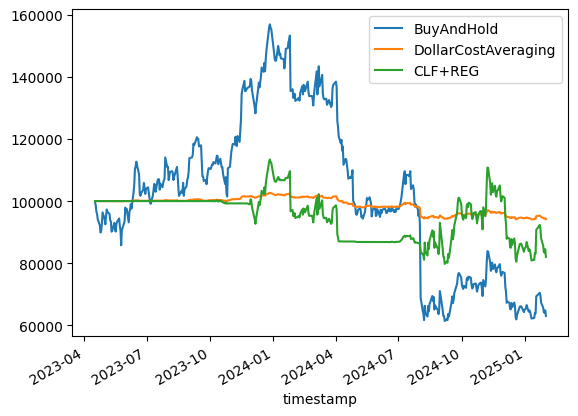

In [14]:
cira.strategy.multi_strategy_backtest(
    [
        cira.strategy.ByAndHold(), 
        cira.strategy.DollarCostAveraging(1), 
        strat
    ], 
    pd.DataFrame(X_test, columns=features), 
    X_test_price.to_frame(), 
    100_000
).plot()

<Axes: >

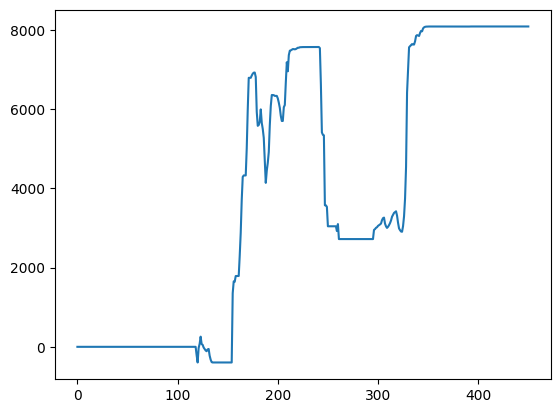

In [15]:
pd.Series(strat.actions).cumsum().plot()

<Axes: >

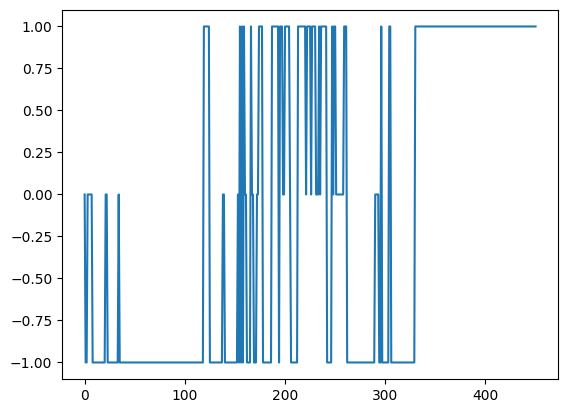

In [16]:
pd.Series(strat.predictions_clf).apply(lambda x: 1 if x == "buy" else -1 if x == "sell" else 0).plot()

<Axes: >

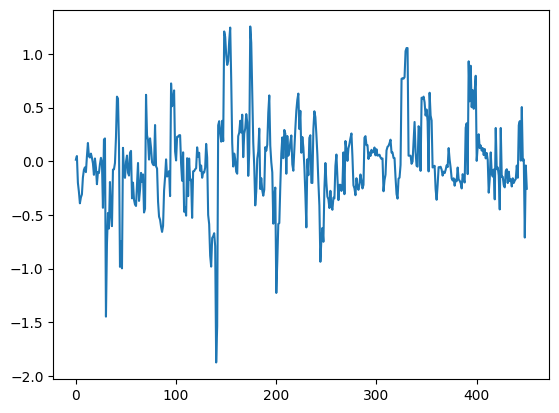

In [17]:
pd.Series(strat.predictions_reg).plot()  